## import required libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# pytorch
import torchvision.models as models 
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision.models import alexnet 
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import CIFAR10
from torch.utils.data import Subset

## Data preprocessing and enhancement


In [2]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    # transforms.RandomHorizontalFlip()
    # transforms.RandomGrayscale()
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

trainset = CIFAR10(root='./cifar10', train=True, download=True, transform=transform)
#trainloader = DataLoader(trainset, batch_size=100, shuffle=True)

testset = CIFAR10(root='./cifar10', train=False, download=True, transform=transform)
#testloader = DataLoader(testset, batch_size=4, shuffle=False)

classDict = {'airplane': 0, 'car': 1, 'bird': 2, 'cat': 3, 'deer': 4,
             'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}
# extract airplane and car classes for trainset
airplane_indices, car_indices = [], []
airplane_idx, car_idx = classDict['airplane'], classDict['car']

for i in range(len(trainset)):
    current_class = trainset[i][1]
    if current_class == airplane_idx:
        airplane_indices.append(i)
    elif current_class == car_idx:
        car_indices.append(i)
new_trainset = Subset(trainset, airplane_indices+car_indices)

# extract airplane and car classes for testset
airplane_indices, car_indices = [], []
airplane_idx, car_idx = classDict['airplane'], classDict['car']

for i in range(len(testset)):
    current_class = testset[i][1]
    if current_class == airplane_idx:
        airplane_indices.append(i)
    elif current_class == car_idx:
        car_indices.append(i)
new_testset = Subset(testset, airplane_indices+car_indices)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
print(len(new_trainset), len(new_testset))

10000 2000


In [4]:
trainloader = DataLoader(new_trainset, batch_size=100, shuffle=True)
testloader = DataLoader(new_testset, batch_size=10, shuffle=False)

In [5]:
Alexnet_model = alexnet(pretrained=True)  
for parameters in Alexnet_model.features.parameters():
    parameters.requires_grad = False

Alexnet_model.classifier._modules['6'] = nn.Linear(4096, 2) # change last FC layer

for parameters in Alexnet_model.classifier.parameters():
    parameters.requires_grad = True
if torch.cuda.is_available():
    Alexnet_model = Alexnet_model.to('cuda')

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:00<00:00, 249MB/s]  


In [6]:
print('alexnet:')
print(Alexnet_model)

alexnet:
AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bia

In [8]:
params = [p for p in Alexnet_model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params,lr=0.001) 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loss_fn = nn.CrossEntropyLoss().to(device)

In [9]:
def model_fit(epoch, model, trainloader, testloader):
    for x_train, y_train in trainloader:
        if torch.cuda.is_available():
            x_train, y_train = x_train.to('cuda'), y_train.to('cuda')
            
        # model.trian() 
        y_pred = model(x_train)
        loss = loss_fn(y_pred, y_train)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()  
        
        correct = 0 
        samples_num = 0 
        epoch_loss_sum = 0 
        with torch.no_grad(): 
            y_pred = torch.argmax(y_pred, dim=1)
            correct += (y_pred == y_train).sum().item()
            samples_num += y_train.size(0)
            epoch_loss_sum += loss.item()
           
    epoch_loss = epoch_loss_sum / len(trainloader.dataset)
    epoch_acc = correct / samples_num
 
    test_correct = 0
    test_samples_num = 0
    test_loss_sum = 0
    model.eval() 
    with torch.no_grad():
        for x_test, y_test in testloader:
            if torch.cuda.is_available():
                x_test, y_test = x_test.to('cuda'), y_test.to('cuda')
            y_pred = model(x_test)
            loss = loss_fn(y_pred, y_test)
            y_pred = torch.argmax(y_pred, dim=1)
            test_correct += (y_pred == y_test).sum().item()
            test_samples_num += y_test.size(0)
            test_loss_sum += loss.item()
 
    epoch_test_loss = test_loss_sum / len(testloader.dataset)
    epoch_test_acc = test_correct / test_samples_num
 
    print(f'epoch: {epoch}, train loss：{epoch_loss:.5}, train accuracy: {epoch_acc:.3%}, test loss：{epoch_test_loss:.5}, test accuracy: {epoch_test_acc:.3%}')
 
    return epoch_loss, epoch_acc, epoch_test_loss, epoch_test_acc

In [10]:
epochs = 15
train_loss = []
train_acc = []
test_loss = []
test_acc = []
Alexnet_model = Alexnet_model.to(device)
for epoch in range(1, epochs + 1):
    epoch_loss, epoch_acc, epoch_test_loss, epoch_test_acc = model_fit(epoch,
                                                                  Alexnet_model,
                                                                  trainloader,
                                                                  testloader)
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)
    test_loss.append(epoch_test_loss)
    test_acc.append(epoch_test_acc)

epoch: 1, train loss：1.0141e-05, train accuracy: 96.000%, test loss：0.012547, test accuracy: 95.200%
epoch: 2, train loss：1.2661e-05, train accuracy: 96.000%, test loss：0.0095281, test accuracy: 96.850%
epoch: 3, train loss：8.4183e-06, train accuracy: 96.000%, test loss：0.0093394, test accuracy: 96.850%
epoch: 4, train loss：2.2244e-06, train accuracy: 99.000%, test loss：0.012538, test accuracy: 96.400%
epoch: 5, train loss：3.9931e-06, train accuracy: 98.000%, test loss：0.014966, test accuracy: 96.050%
epoch: 6, train loss：3.1413e-06, train accuracy: 99.000%, test loss：0.010585, test accuracy: 97.350%
epoch: 7, train loss：1.8375e-07, train accuracy: 100.000%, test loss：0.017476, test accuracy: 96.600%
epoch: 8, train loss：1.731e-07, train accuracy: 100.000%, test loss：0.016706, test accuracy: 96.400%
epoch: 9, train loss：3.9525e-06, train accuracy: 99.000%, test loss：0.025049, test accuracy: 95.750%
epoch: 10, train loss：2.4398e-06, train accuracy: 99.000%, test loss：0.015223, test accu

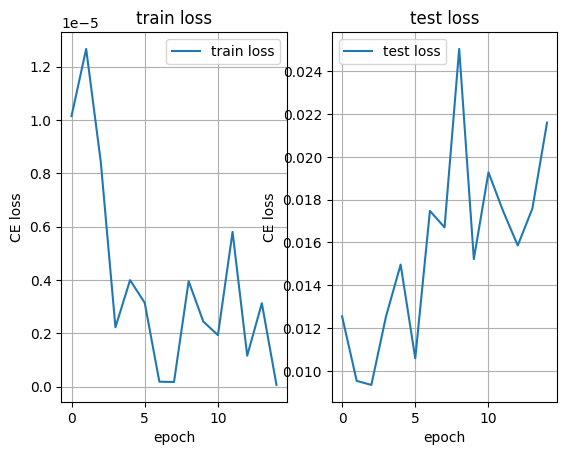

In [11]:
fig, axs = plt.subplots(1, 2)
axs[0].set_title('train loss')
axs[0].set_xlabel('epoch')
axs[0].set_ylabel('CE loss')
axs[0].grid(True)
axs[0].plot(train_loss, label='train loss')
axs[0].legend()
axs[1].set_title('test loss')
axs[1].set_xlabel('epoch')
axs[1].set_ylabel('CE loss')
axs[1].grid(True)
axs[1].plot(test_loss, label='test loss')
axs[1].legend()

It can be seen from test loss that after some epoches, test loss increased, and obvious over-fitting phenomenon appeared (but test acc was approximately flat).

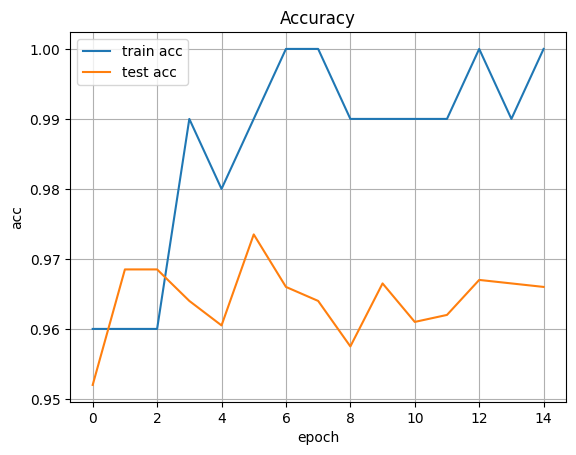

In [12]:
plt.figure(2)
plt.title('Accuracy')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.grid(True)
plt.plot(train_acc, label='train acc')
plt.plot(test_acc, label='test acc')
plt.legend()

In [13]:
print('test accuracy =', test_acc[-1])

test accuracy = 0.966


## Using triplet loss instead of CE loss

#### Define class CIFAR10

I'll define class CIFAR10 which was inherited torch.utils.data.Dataset.

In [14]:

class MyCifar10(CIFAR10):
    airplane_idx, car_idx = classDict['airplane'], classDict['car']
    def __init__(self, root, transforms, train=True):
        super().__init__(root, train, download=True)
        self.transforms = transforms

    def __getitem__(self, index):
        im, label = super().__getitem__(index)
        if label==airplane_idx or label==car_idx:
            positive_im, negative_im = None, None
            while(positive_im is None or negative_im is None):
                random_index = np.random.randint(self.__len__())
                random_im, random_label = super().__getitem__(random_index)
                if random_label==airplane_idx or random_label==car_idx:
                    if random_label == label:
                        positive_im = random_im
                    else:
                        negative_im = random_im
            return self.transforms(im), self.transforms(positive_im), self.transforms(negative_im), label
        else:
            return self.transforms(im), label

In [15]:
trainset = MyCifar10(root='./cifar10', train=True, transforms=transform)
#trainloader = DataLoader(trainset, batch_size=100, shuffle=True)

testset = MyCifar10(root='./cifar10', train=False, transforms=transform)
#testloader = DataLoader(testset, batch_size=4, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [16]:
# extract airplane and car classes for trainset
airplane_indices, car_indices = [], []
airplane_idx, car_idx = classDict['airplane'], classDict['car']

for i in range(len(trainset)):
    current_class = trainset[i][-1]
    if current_class == airplane_idx:
        airplane_indices.append(i)
    elif current_class == car_idx:
        car_indices.append(i)
new_trainset = Subset(trainset, airplane_indices+car_indices)

# extract airplane and car classes for testset
airplane_indices, car_indices = [], []
airplane_idx, car_idx = classDict['airplane'], classDict['car']

for i in range(len(testset)):
    current_class = testset[i][-1]
    if current_class == airplane_idx:
        airplane_indices.append(i)
    elif current_class == car_idx:
        car_indices.append(i)
new_testset = Subset(testset, airplane_indices+car_indices)

In [17]:
trainloader = DataLoader(new_trainset, batch_size=100, shuffle=True)
testloader = DataLoader(new_testset, batch_size=10, shuffle=False)

#### Define TripletLoss

In [18]:
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin
        
    def calc_euclidean(self, x1, x2):
        return (x1 - x2).pow(2).sum(1)
    
    def forward(self, anchor: torch.Tensor, positive: torch.Tensor, negative: torch.Tensor) -> torch.Tensor:
        distance_positive = self.calc_euclidean(anchor, positive)
        distance_negative = self.calc_euclidean(anchor, negative)
        losses = torch.relu(distance_positive - distance_negative + self.margin)

        return losses.mean()

In [19]:
Alexnet_model = alexnet(pretrained=True)
Alexnet_model.classifier._modules['6'] = nn.Linear(4096, 2) # change last FC layer

for parameters in Alexnet_model.features.parameters():
    parameters.requires_grad = True

for parameters in Alexnet_model.classifier.parameters():
    parameters.requires_grad = False
if torch.cuda.is_available():
    Alexnet_model = Alexnet_model.to('cuda')

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
params = [p for p in Alexnet_model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params,lr=0.001)
triplet_criterion = TripletLoss().to(device)

In [22]:
def model_feature_extractor(epoch, model, trainloader, device):
    running_loss = []
    model.train()
    cnn_layer = model.features
    for step, (anchor_img, positive_img, negative_img, anchor_label) in enumerate(trainloader):

        anchor_img = anchor_img.to(device)
        positive_img = positive_img.to(device)
        negative_img = negative_img.to(device)

        # model.trian()
        anchor_out = cnn_layer(anchor_img)
        positive_out = cnn_layer(positive_img)
        negative_out = cnn_layer(negative_img)

        loss = triplet_criterion(anchor_out, positive_out, negative_out)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        running_loss.append(loss.cpu().detach().numpy())

    epoch_loss = np.mean(running_loss)

    print(f'epoch: {epoch}, train loss：{epoch_loss:.5}')

    return epoch_loss

### featur extractor

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 15
train_loss = []
Alexnet_model = Alexnet_model.to(device)
for epoch in range(1, epochs + 1):
    epoch_loss = model_feature_extractor(epoch, Alexnet_model, trainloader, device)
    train_loss.append(epoch_loss)

epoch: 1, train loss：1.2514
epoch: 2, train loss：0.73428
epoch: 3, train loss：0.68844
epoch: 4, train loss：0.60981
epoch: 5, train loss：0.55883
epoch: 6, train loss：0.5366
epoch: 7, train loss：0.27679
epoch: 8, train loss：0.10014
epoch: 9, train loss：0.071917
epoch: 10, train loss：0.051839
epoch: 11, train loss：0.034655
epoch: 12, train loss：0.02748
epoch: 13, train loss：0.014748
epoch: 14, train loss：0.021446
epoch: 15, train loss：0.025403


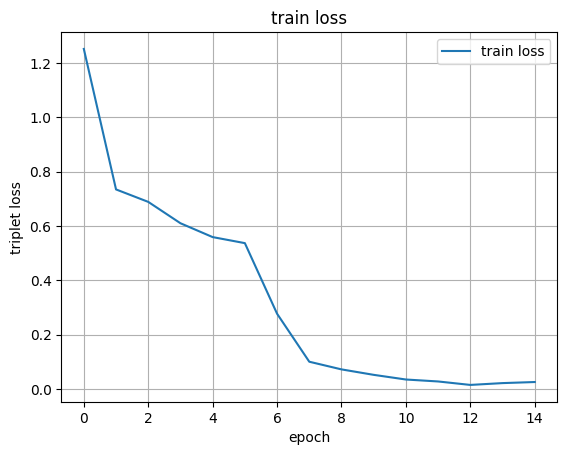

In [25]:
plt.figure()
plt.title('train loss')
plt.xlabel('epoch')
plt.ylabel('triplet loss')
plt.grid(True)
plt.plot(train_loss, label='train loss')
plt.legend()


### fully connected layers


In [28]:
for parameters in Alexnet_model.features.parameters():
    parameters.requires_grad = False

for parameters in Alexnet_model.classifier.parameters():
    parameters.requires_grad = True

Alexnet_model = Alexnet_model.to(device)

In [29]:
params = [p for p in Alexnet_model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params,lr=0.001)
loss_fn = nn.CrossEntropyLoss().to(device)

In [30]:
def model_fit_FCLayer(epoch, model, trainloader, testloader, device):
    for x_train, positive_img, negative_img, y_train in trainloader:
        x_train = x_train.to(device)
        y_train = y_train.to(device)
        #positive_img = positive_img.to(device)
        #negative_img = negative_img.to(device)
            
        # model.trian() 
        model.train()
        y_pred = model(x_train)
        loss = loss_fn(y_pred, y_train)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()  
        
        correct = 0 
        samples_num = 0 
        epoch_loss_sum = 0 
        with torch.no_grad(): 
            y_pred = torch.argmax(y_pred, dim=1)
            correct += (y_pred == y_train).sum().item()
            samples_num += y_train.size(0)
            epoch_loss_sum += loss.item()
           
    epoch_loss = epoch_loss_sum / len(trainloader.dataset)
    epoch_acc = correct / samples_num
 
    test_correct = 0
    test_samples_num = 0
    test_loss_sum = 0
    model.eval() 
    with torch.no_grad():
        for x_test,_,_, y_test in testloader:
            x_test, y_test = x_test.to(device), y_test.to(device)
            y_pred = model(x_test)
            loss = loss_fn(y_pred, y_test)
            y_pred = torch.argmax(y_pred, dim=1)
            test_correct += (y_pred == y_test).sum().item()
            test_samples_num += y_test.size(0)
            test_loss_sum += loss.item()
 
    epoch_test_loss = test_loss_sum / len(testloader.dataset)
    epoch_test_acc = test_correct / test_samples_num
 
    print(f'epoch: {epoch}, train loss：{epoch_loss:.5}, train accuracy: {epoch_acc:.3%}, test loss：{epoch_test_loss:.5}, test accuracy: {epoch_test_acc:.3%}')
 
    return epoch_loss, epoch_acc, epoch_test_loss, epoch_test_acc

In [32]:
epochs = 15
train_loss = []
train_acc = []
test_loss = []
test_acc = []
Alexnet_model = Alexnet_model.to(device)
for epoch in range(1, epochs + 1):
    epoch_loss, epoch_acc, epoch_test_loss, epoch_test_acc = model_fit_FCLayer(epoch, Alexnet_model, trainloader, testloader, device)
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)
    test_loss.append(epoch_test_loss)
    test_acc.append(epoch_test_acc)

epoch: 1, train loss：7.6296e-08, train accuracy: 100.000%, test loss：0.014675, test accuracy: 97.400%
epoch: 2, train loss：7.2758e-09, train accuracy: 100.000%, test loss：0.013883, test accuracy: 97.400%
epoch: 3, train loss：1.4328e-07, train accuracy: 100.000%, test loss：0.013834, test accuracy: 97.500%
epoch: 4, train loss：3.5902e-09, train accuracy: 100.000%, test loss：0.021787, test accuracy: 97.350%
epoch: 5, train loss：5.1202e-08, train accuracy: 100.000%, test loss：0.016394, test accuracy: 97.700%
epoch: 6, train loss：2.0997e-05, train accuracy: 98.000%, test loss：0.023372, test accuracy: 97.350%
epoch: 7, train loss：1.3924e-09, train accuracy: 100.000%, test loss：0.025821, test accuracy: 97.150%
epoch: 8, train loss：3.4405e-08, train accuracy: 100.000%, test loss：0.013059, test accuracy: 97.250%
epoch: 9, train loss：5.222e-09, train accuracy: 100.000%, test loss：0.033119, test accuracy: 97.450%
epoch: 10, train loss：6.5481e-07, train accuracy: 100.000%, test loss：0.021142, test

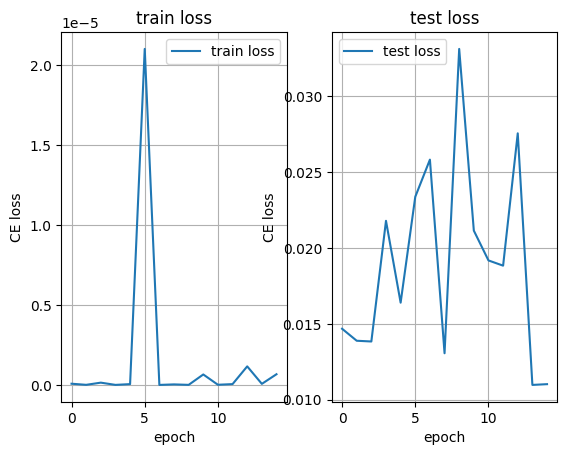

In [33]:
fig, axs = plt.subplots(1, 2)
axs[0].set_title('train loss')
axs[0].set_xlabel('epoch')
axs[0].set_ylabel('CE loss')
axs[0].grid(True)
axs[0].plot(train_loss, label='train loss')
axs[0].legend()
axs[1].set_title('test loss')
axs[1].set_xlabel('epoch')
axs[1].set_ylabel('CE loss')
axs[1].grid(True)
axs[1].plot(test_loss, label='test loss')
axs[1].legend()

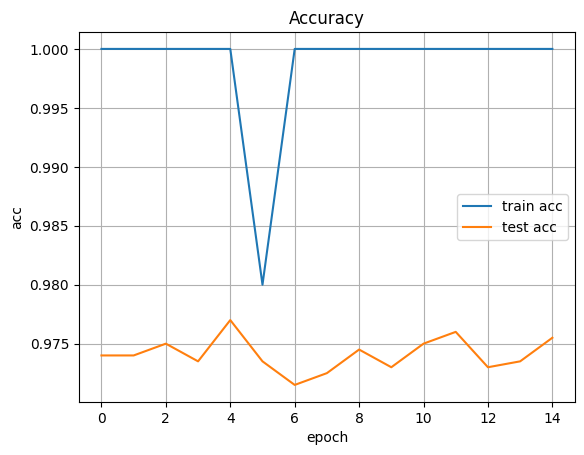

In [34]:
plt.figure(2)
plt.title('Accuracy')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.grid(True)
plt.plot(train_acc, label='train acc')
plt.plot(test_acc, label='test acc')
plt.legend()

In [36]:
print(f'test accuracy = {test_acc[-1]:.3%}')

test accuracy = 97.550%


### trainnig all parameters of the model with Loss_total = triplet_loss + CE_loss 

In [37]:
for parameters in Alexnet_model.features.parameters():
    parameters.requires_grad = True

for parameters in Alexnet_model.classifier.parameters():
    parameters.requires_grad = True

Alexnet_model = Alexnet_model.to(device)

In [38]:
params = [p for p in Alexnet_model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params,lr=0.001)
loss_fn = nn.CrossEntropyLoss().to(device)
triplet_criterion = TripletLoss().to(device)

In [39]:
def model_fit_total(epoch, model, trainloader, testloader, device):
    #model.train()
    cnn_layer = model.features
    for x_train, positive_img, negative_img, y_train in trainloader:
        x_train = x_train.to(device)
        y_train = y_train.to(device)
        positive_img = positive_img.to(device)
        negative_img = negative_img.to(device)
            
        model.train()
        y_pred = model(x_train)
        anchor_out = cnn_layer(x_train)
        positive_out = cnn_layer(positive_img)
        negative_out = cnn_layer(negative_img)
        triplet_loss = triplet_criterion(anchor_out, positive_out, negative_out)
        CEloss = loss_fn(y_pred, y_train)
        loss = triplet_loss + CEloss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()  
        
        correct = 0 
        samples_num = 0 
        epoch_loss_sum = 0 
        with torch.no_grad(): 
            y_pred = torch.argmax(y_pred, dim=1)
            correct += (y_pred == y_train).sum().item()
            samples_num += y_train.size(0)
            epoch_loss_sum += loss.item()
           
    epoch_loss = epoch_loss_sum / len(trainloader.dataset)
    epoch_acc = correct / samples_num
 
    test_correct = 0
    test_samples_num = 0
    test_loss_sum = 0
    model.eval() 
    with torch.no_grad():
        for x_test, positive_img, negative_img, y_test in testloader:
            x_test, y_test = x_test.to(device), y_test.to(device)
            positive_img, negative_img = positive_img.to(device), negative_img.to(device)
            y_pred = model(x_test)
            anchor_out = cnn_layer(x_test)
            positive_out = cnn_layer(positive_img)
            negative_out = cnn_layer(negative_img)
            triplet_loss = triplet_criterion(anchor_out, positive_out, negative_out)
            CEloss = loss_fn(y_pred, y_test)
            loss = triplet_loss + CEloss
            y_pred = torch.argmax(y_pred, dim=1)
            test_correct += (y_pred == y_test).sum().item()
            test_samples_num += y_test.size(0)
            test_loss_sum += loss.item()
 
    epoch_test_loss = test_loss_sum / len(testloader.dataset)
    epoch_test_acc = test_correct / test_samples_num
 
    print(f'epoch: {epoch}, train loss：{epoch_loss:.5}, train accuracy: {epoch_acc:.3%}, test loss：{epoch_test_loss:.5}, test accuracy: {epoch_test_acc:.3%}')
 
    return epoch_loss, epoch_acc, epoch_test_loss, epoch_test_acc

In [40]:
epochs = 15
train_loss = []
train_acc = []
test_loss = []
test_acc = []
Alexnet_model = Alexnet_model.to(device)
for epoch in range(1, epochs + 1):
    epoch_loss, epoch_acc, epoch_test_loss, epoch_test_acc = model_fit_total(epoch, Alexnet_model, trainloader, testloader, device)
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)
    test_loss.append(epoch_test_loss)
    test_acc.append(epoch_test_acc)

epoch: 1, train loss：6.8357e-06, train accuracy: 99.000%, test loss：0.025826, test accuracy: 96.600%
epoch: 2, train loss：1.7092e-06, train accuracy: 100.000%, test loss：0.023956, test accuracy: 97.100%
epoch: 3, train loss：1.9533e-05, train accuracy: 99.000%, test loss：0.026433, test accuracy: 96.850%
epoch: 4, train loss：1.4589e-06, train accuracy: 100.000%, test loss：0.032019, test accuracy: 97.350%
epoch: 5, train loss：7.2499e-06, train accuracy: 99.000%, test loss：0.034928, test accuracy: 95.700%
epoch: 6, train loss：1.2516e-06, train accuracy: 100.000%, test loss：0.022742, test accuracy: 97.450%
epoch: 7, train loss：4.3633e-06, train accuracy: 100.000%, test loss：0.037419, test accuracy: 94.350%
epoch: 8, train loss：4.0059e-06, train accuracy: 98.000%, test loss：0.027326, test accuracy: 97.200%
epoch: 9, train loss：4.7246e-07, train accuracy: 100.000%, test loss：0.024727, test accuracy: 97.650%
epoch: 10, train loss：2.363e-06, train accuracy: 99.000%, test loss：0.022562, test acc

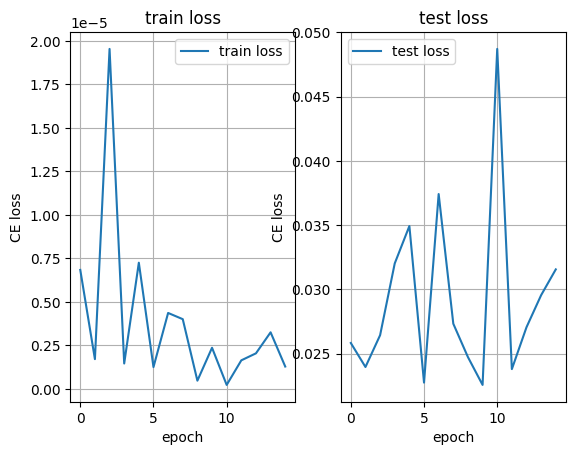

In [41]:
fig, axs = plt.subplots(1, 2)
axs[0].set_title('train loss')
axs[0].set_xlabel('epoch')
axs[0].set_ylabel('CE loss')
axs[0].grid(True)
axs[0].plot(train_loss, label='train loss')
axs[0].legend()
axs[1].set_title('test loss')
axs[1].set_xlabel('epoch')
axs[1].set_ylabel('CE loss')
axs[1].grid(True)
axs[1].plot(test_loss, label='test loss')
axs[1].legend()

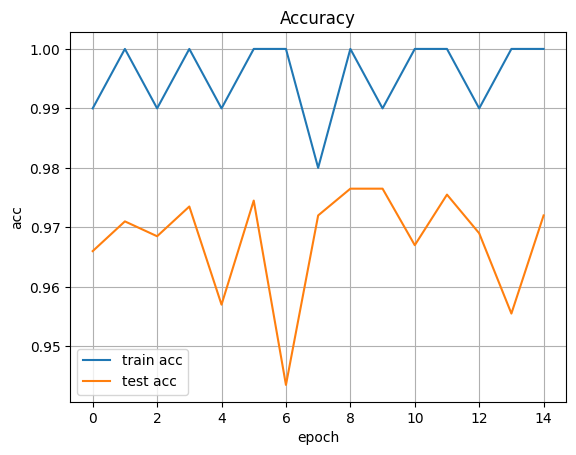

In [42]:
plt.figure(2)
plt.title('Accuracy')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.grid(True)
plt.plot(train_acc, label='train acc')
plt.plot(test_acc, label='test acc')
plt.legend()

In [43]:
print(f'test accuracy = {test_acc[-1]:.3%}')

test accuracy = 97.200%
